## Dipole calculations using events file instead of flux file

In [2]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt

# Load the event file
data = ascii.read("../data/Auger/events_a8_lb.dat")

# Extract columns
RA = np.deg2rad(data['RA'])          # RA in radians
dec = np.deg2rad(data['dec'])        # Dec in radians
azimuth = np.deg2rad(data['azimuth'])  # Azimuth in radians
weights = data['weight']             # Provided event weights

# Total normalized weight
W = np.sum(weights)

# --- 2D Dipole: Rayleigh analysis in RA ---
a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))

r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
phi_alpha = np.arctan2(b_alpha, a_alpha) % (2 * np.pi)
phi_alpha_deg = np.rad2deg(phi_alpha)

print("=== 2D Dipole in Right Ascension ===")
print(f"Amplitude (r_alpha): {r_alpha:.4f}")
print(f"Phase (RA): {phi_alpha_deg:.2f}°")

# --- 3D Dipole Reconstruction ---
# Use values from the paper unless zenith is available
mean_cos_dec = np.mean(np.cos(dec))  # <cos δ>
mean_sin_theta = 0.65                # Paper's ⟨sin θ⟩
lat_obs = np.deg2rad(-35.2)          # Observatory latitude

d_perp = r_alpha / mean_cos_dec
b_phi = (2.0 / W) * np.sum(weights * np.sin(azimuth))
d_z = b_phi / (np.cos(lat_obs) * mean_sin_theta)

dipole_amp = np.sqrt(d_perp**2 + d_z**2)
delta_d = np.rad2deg(np.arctan2(d_z, d_perp))
alpha_d = phi_alpha_deg

print("\n=== 3D Dipole ===")
print(f"Dipole amplitude: {dipole_amp:.4f}")
print(f"Dipole direction: RA = {alpha_d:.2f}°, Dec = {delta_d:.2f}°")


=== 2D Dipole in Right Ascension ===
Amplitude (r_alpha): 0.0466
Phase (RA): 100.34°

=== 3D Dipole ===
Dipole amplitude: 0.0652
Dipole direction: RA = 100.34°, Dec = -23.80°


In [3]:
# Compute Neff
W = np.sum(weights)
Weff = W**2 / np.sum(weights**2)
sigma_r = np.sqrt(2 / Weff)
sigma_phi_rad = sigma_r / r_alpha
sigma_phi_deg = np.rad2deg(sigma_phi_rad)

print("=== Analytical Uncertainties ===")
print(f"σ_r_alpha ≈ {sigma_r:.4f} ({sigma_r * 100:.2f}%)")
print(f"σ_phi_alpha ≈ {sigma_phi_deg:.2f}°")


=== Analytical Uncertainties ===
σ_r_alpha ≈ 0.0079 (0.79%)
σ_phi_alpha ≈ 9.69°


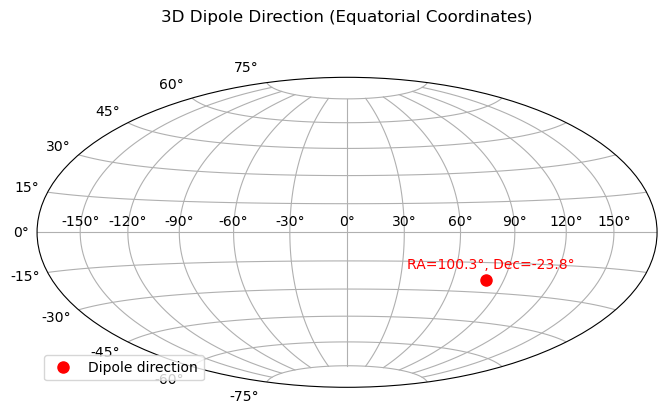

In [4]:
import matplotlib.pyplot as plt

# Convert RA/Dec to radians for plotting
ra_dipole = np.deg2rad(alpha_d)
dec_dipole = np.deg2rad(delta_d)

# Shift RA to [-π, π] for Hammer projection
ra_plot = -(ra_dipole - np.pi)

plt.figure(figsize=(8, 5))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

# Plot the dipole direction
ax.plot(ra_plot, dec_dipole, 'ro', markersize=8, label='Dipole direction')

# Annotate
ax.text(ra_plot, dec_dipole + 0.1, f'RA={alpha_d:.1f}°, Dec={delta_d:.1f}°', ha='center', color='red')
plt.title("3D Dipole Direction (Equatorial Coordinates)", pad=40)
plt.legend(loc='lower left')
plt.show()


=== Galaxy Dipole Analysis ===
2D amplitude (r_alpha): 0.0772
RA phase: 43.74°
Projected 3D dipole amplitude: 0.0950
Direction: RA = 43.74°, Dec = 0.00°
σ_r_alpha ≈ 0.0130 (1.30%)
σ_phi_alpha ≈ 9.62°
Rayleigh p-value: 1.96e-08
Gaussian significance: 5.49 σ
Angular separation with Auger dipole: 59.51°


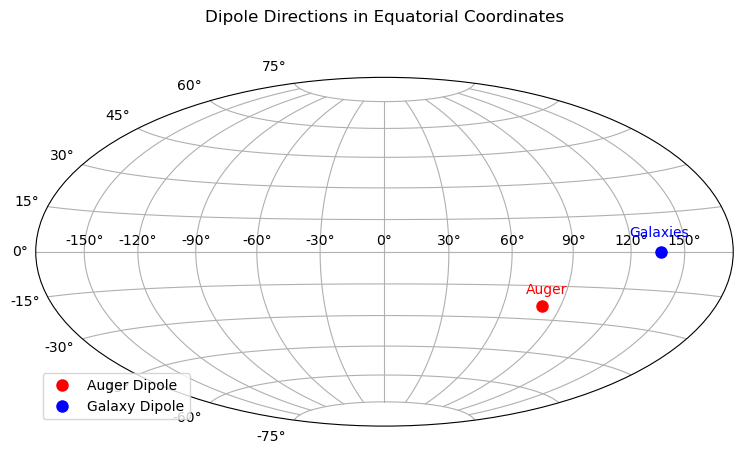

In [6]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.special import erfinv

# === Load Galaxy Catalog ===
galaxies = ascii.read('../data/2MRSxWISE_sinBPTAGNs.txt')  
RA = np.deg2rad(galaxies['_RAJ2000'])
Dec = np.deg2rad(galaxies['_DEJ2000'])
weights = np.ones(len(RA))

# === 2D Rayleigh Dipole in RA ===
W = np.sum(weights)
a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
phi_alpha = np.arctan2(b_alpha, a_alpha) % (2 * np.pi)
phi_alpha_deg = np.rad2deg(phi_alpha)

# === Partial 3D Dipole (d_z = 0) ===
mean_cos_dec = np.mean(np.cos(Dec))
d_perp = r_alpha / mean_cos_dec
dipole_amp = d_perp
alpha_d = phi_alpha_deg
delta_d = 0.0

# === Analytical Uncertainties and Significance ===
Weff = W**2 / np.sum(weights**2)
sigma_r = np.sqrt(2 / Weff)
sigma_phi_deg = np.rad2deg(sigma_r / r_alpha)
P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)
Z = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh)

# === Print Results ===
print("=== Galaxy Dipole Analysis ===")
print(f"2D amplitude (r_alpha): {r_alpha:.4f}")
print(f"RA phase: {phi_alpha_deg:.2f}°")
print(f"Projected 3D dipole amplitude: {dipole_amp:.4f}")
print(f"Direction: RA = {alpha_d:.2f}°, Dec = {delta_d:.2f}°")
print(f"σ_r_alpha ≈ {sigma_r:.4f} ({sigma_r*100:.2f}%)")
print(f"σ_phi_alpha ≈ {sigma_phi_deg:.2f}°")
print(f"Rayleigh p-value: {P_rayleigh:.2e}")
print(f"Gaussian significance: {Z:.2f} σ")

# === Auger Dipole ===
auger_RA_deg = 100
auger_Dec_deg = -24

# === Angular Separation ===
dipole_gal = SkyCoord(ra=alpha_d*u.deg, dec=delta_d*u.deg, frame='icrs')
dipole_aug = SkyCoord(ra=auger_RA_deg*u.deg, dec=auger_Dec_deg*u.deg, frame='icrs')
angle_sep = dipole_gal.separation(dipole_aug)

print(f"Angular separation with Auger dipole: {angle_sep.deg:.2f}°")

# === Plotting Both Dipoles ===
# Convert to Hammer projection coordinates
ra_gal_rad = np.deg2rad(alpha_d)
dec_gal_rad = np.deg2rad(delta_d)
ra_aug_rad = np.deg2rad(auger_RA_deg)
dec_aug_rad = np.deg2rad(auger_Dec_deg)

ra_gal_plot = -(ra_gal_rad - np.pi)
ra_aug_plot = -(ra_aug_rad - np.pi)

plt.figure(figsize=(9, 5))
ax = plt.subplot(111, projection="hammer")
ax.grid(True)

ax.plot(ra_aug_plot, dec_aug_rad, 'ro', label="Auger Dipole", markersize=8)
ax.plot(ra_gal_plot, dec_gal_rad, 'bo', label="Galaxy Dipole", markersize=8)

ax.text(ra_aug_plot, dec_aug_rad + 0.1, "Auger", ha='center', color='red')
ax.text(ra_gal_plot, dec_gal_rad + 0.1, "Galaxies", ha='center', color='blue')

plt.title("Dipole Directions in Equatorial Coordinates", pad=40)
plt.legend(loc='lower left')
plt.show()


/tmp/ipykernel_52696/417733474.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', n_bins)



=== Dipole for cz 1200-2200 km/s ===
N = 73 galaxies
RA = 176.34°, Dec = -20.98°
r_alpha = 0.9207, d_perp = 0.0875
σ_r = 0.1655, σ_phi = 10.30°
Significance: 5.08 σ, p = 1.91e-07

=== Dipole for cz 2200-3200 km/s ===
N = 198 galaxies
RA = 186.34°, Dec = -47.82°
r_alpha = 0.5656, d_perp = 0.0875
σ_r = 0.1005, σ_phi = 10.18°
Significance: 5.15 σ, p = 1.33e-07

=== Dipole for cz 3200-4200 km/s ===
N = 333 galaxies
RA = 148.80°, Dec = -26.09°
r_alpha = 0.3417, d_perp = 0.0875
σ_r = 0.0775, σ_phi = 13.00°
Significance: 3.85 σ, p = 6.01e-05

=== Dipole for cz 4200-5200 km/s ===
N = 877 galaxies
RA = 22.70°, Dec = 11.87°
r_alpha = 0.4127, d_perp = 0.0875
σ_r = 0.0478, σ_phi = 6.63°
Significance: 8.29 σ, p = 6.02e-17

=== Dipole for cz 5200-6200 km/s ===
N = 1258 galaxies
RA = 21.91°, Dec = 16.37°
r_alpha = 0.4537, d_perp = 0.0875
σ_r = 0.0399, σ_phi = 5.04°
Significance: inf σ, p = 7.66e-29

=== Dipole for cz 6200-7200 km/s ===
N = 1384 galaxies
RA = 162.68°, Dec = 58.40°
r_alpha = 0.1915, d

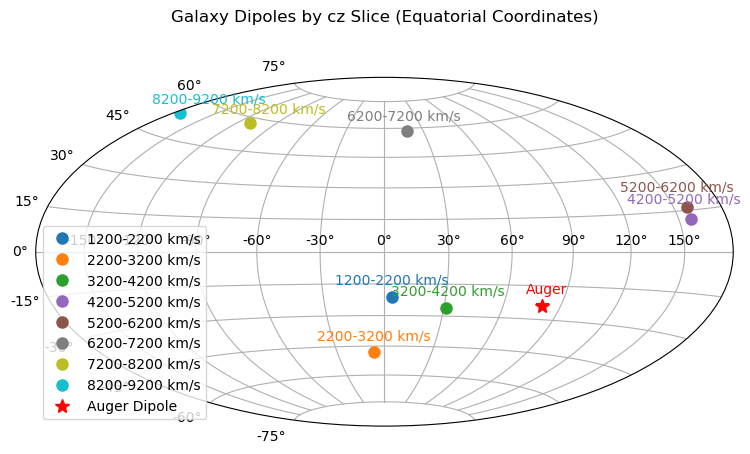

In [11]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.special import erfinv
import matplotlib.cm as cm

# === Load Galaxy Catalog ===
gxs = ascii.read("../data/2MRSxWISE_sinBPTAGNs.txt")  # Update path
RA_all = np.deg2rad(gxs['_RAJ2000'])
Dec_all = np.deg2rad(gxs['_DEJ2000'])
cz_all = gxs['cz']
weights_all = np.ones(len(RA_all))

# === Define cz bins here ===
# You can change this list to customize the slices
# cz_bins = [
#     (1200, 3600),
#     (4000, 5000),
#     (9000, 9400)
# ]
# To cover full range in slices of 1000 km/s:
cz_bins = [(cz, cz + 1000) for cz in range(1200, 9000, 1000)]

# === Setup for plotting and storage ===
n_bins = len(cz_bins)
colors = cm.get_cmap('tab10', n_bins)
dipole_results = {}

# === Loop over cz bins ===
for i, (cz_min, cz_max) in enumerate(cz_bins):
    label = f"{cz_min}-{cz_max} km/s"
    color = colors(i)
    
    # Apply cz mask
    mask = (cz_all > cz_min) & (cz_all < cz_max)
    RA = RA_all[mask]
    Dec = Dec_all[mask]
    weights = weights_all[mask]
    
    if len(RA) < 10:
        print(f"Skipping {label} — too few galaxies ({len(RA)})")
        continue

    # 2D dipole
    W = np.sum(weights)
    a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
    b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
    r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
    phi_alpha = np.arctan2(b_alpha, a_alpha) % (2 * np.pi)
    phi_alpha_deg = np.rad2deg(phi_alpha)

    # Compute full 3D dipole direction
    x = np.cos(Dec) * np.cos(RA)
    y = np.cos(Dec) * np.sin(RA)
    z = np.sin(Dec)

    # Weighted sum of unit vectors
    X = np.sum(weights * x)
    Y = np.sum(weights * y)
    Z = np.sum(weights * z)

    # Normalize
    norm = np.sqrt(X**2 + Y**2 + Z**2)
    X /= norm
    Y /= norm
    Z /= norm

    # Dipole amplitude (normalized vector)
    dipole_amp = norm / np.sum(weights)

    # Convert vector back to (RA, Dec)
    alpha_d = (np.arctan2(Y, X) % (2 * np.pi)) * 180/np.pi
    delta_d = np.arcsin(Z) * 180/np.pi


    # Uncertainty and significance
    Weff = W**2 / np.sum(weights**2)
    sigma_r = np.sqrt(2 / Weff)
    sigma_phi_deg = np.rad2deg(sigma_r / r_alpha)
    P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)
    Z = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh)

    # Store
    dipole_results[label] = {
        'RA': alpha_d,
        'Dec': delta_d,
        'r_alpha': r_alpha,
        'd_perp': d_perp,
        'σ_r': sigma_r,
        'σ_phi': sigma_phi_deg,
        'Z': Z,
        'P': P_rayleigh,
        'N': len(RA),
        'color': color
    }

    # Print
    print(f"\n=== Dipole for cz {label} ===")
    print(f"N = {len(RA)} galaxies")
    print(f"RA = {alpha_d:.2f}°, Dec = {delta_d:.2f}°")
    print(f"r_alpha = {r_alpha:.4f}, d_perp = {d_perp:.4f}")
    print(f"σ_r = {sigma_r:.4f}, σ_phi = {sigma_phi_deg:.2f}°")
    print(f"Significance: {Z:.2f} σ, p = {P_rayleigh:.2e}")

# === Plot all dipoles ===
plt.figure(figsize=(9, 5))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

for label, res in dipole_results.items():
    ra_rad = np.deg2rad(res['RA'])
    dec_rad = np.deg2rad(res['Dec'])
    ra_plot = -(ra_rad - np.pi)
    ax.plot(ra_plot, dec_rad, 'o', color=res['color'], label=label, markersize=8)
    ax.text(ra_plot, dec_rad + 0.1, label, ha='center', color=res['color'])

# Add Auger dipole for reference
auger_ra = np.deg2rad(100)
auger_dec = np.deg2rad(-24)
auger_ra_plot = -(auger_ra - np.pi)
ax.plot(auger_ra_plot, auger_dec, 'r*', markersize=10, label='Auger Dipole')
ax.text(auger_ra_plot, auger_dec + 0.1, "Auger", ha='center', color='red')

plt.title("Galaxy Dipoles by cz Slice (Equatorial Coordinates)", pad=40)
plt.legend(loc='lower left')
plt.show()


/tmp/ipykernel_52696/659978237.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', n_bins)



=== Dipole for Full Sample ===
N = 8021 galaxies
RA = 17.60° ± 13.30°
Dec = 57.21° ± 13.30°
Amplitude = 0.0599
Significance = 3.74 σ (p = 9.31e-05)
Angular separation from Auger = 106.05°

=== Dipole for 1200-2200 km/s ===
N = 73 galaxies
RA = 176.34° ± 10.30°
Dec = -20.98° ± 10.30°
Amplitude = 0.4135
Significance = 5.08 σ (p = 1.91e-07)
Angular separation from Auger = 69.69°

=== Dipole for 2200-3200 km/s ===
N = 198 galaxies
RA = 186.34° ± 10.18°
Dec = -47.82° ± 10.18°
Amplitude = 0.3276
Significance = 5.15 σ (p = 1.33e-07)
Angular separation from Auger = 70.09°

=== Dipole for 3200-4200 km/s ===
N = 333 galaxies
RA = 148.80° ± 13.00°
Dec = -26.09° ± 13.00°
Amplitude = 0.1542
Significance = 3.85 σ (p = 6.01e-05)
Angular separation from Auger = 44.00°

=== Dipole for 4200-5200 km/s ===
N = 877 galaxies
RA = 22.70° ± 6.63°
Dec = 11.87° ± 6.63°
Amplitude = 0.1729
Significance = 8.29 σ (p = 6.02e-17)
Angular separation from Auger = 83.52°

=== Dipole for 5200-6200 km/s ===
N = 1258 gala

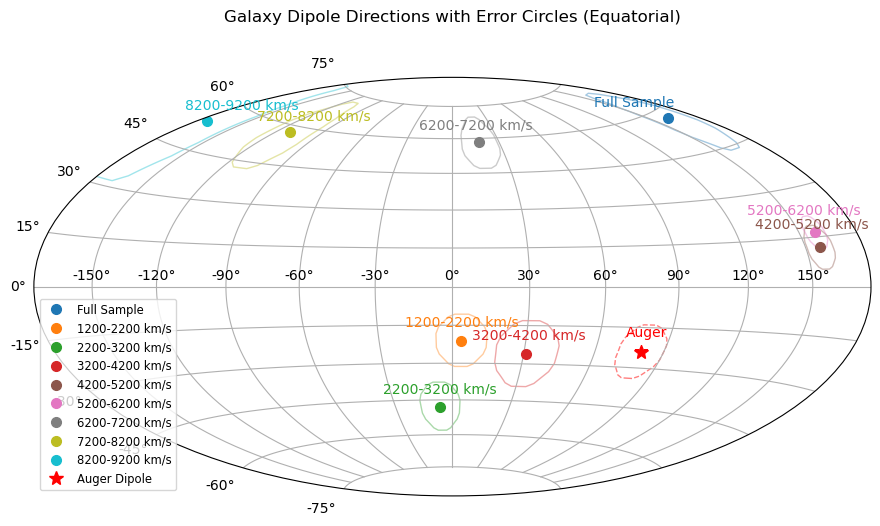

In [18]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.special import erfinv
import matplotlib.cm as cm

# === Load galaxy catalogue ===
gxs = ascii.read("../data/2MRSxWISE_sinBPTAGNs.txt")
RA_all = np.deg2rad(gxs['_RAJ2000'])
Dec_all = np.deg2rad(gxs['_DEJ2000'])
cz_all = gxs['cz']
weights_all = np.ones(len(RA_all))

# === Define cz bins ===
cz_bins = [
    (1200, 9000),       # Full sample
    (1200, 3600),
    (4000, 5000),
    (9000, 9400)
]
cz_bins = [(cz, cz + 1000) for cz in range(1200, 9000, 1000)]
cz_bins.insert(0, (1200, 9000))  # Add full sample as first bin

# === Setup colors and storage ===
n_bins = len(cz_bins)
colors = cm.get_cmap('tab10', n_bins)
dipole_results = {}

# === Auger reference dipole ===
auger_RA = 100.0
auger_Dec = -24.0
auger_coord = SkyCoord(ra=auger_RA * u.deg, dec=auger_Dec * u.deg, frame='icrs')
auger_error_deg = 10.0  # Typical uncertainty in Auger dipole direction

# === Loop through bins ===
for i, (cz_min, cz_max) in enumerate(cz_bins):
    label = "Full Sample" if i == 0 else f"{cz_min}-{cz_max} km/s"
    color = colors(i)

    # Filter galaxies
    mask = (cz_all > cz_min) & (cz_all < cz_max)
    RA = RA_all[mask]
    Dec = Dec_all[mask]
    weights = weights_all[mask]

    if len(RA) < 10:
        print(f"Skipping {label} — too few galaxies ({len(RA)})")
        continue

    W = np.sum(weights)

    # === 2D Rayleigh dipole ===
    a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
    b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
    r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
    phi_alpha_deg = np.rad2deg(np.arctan2(b_alpha, a_alpha) % (2 * np.pi))

    # === 3D dipole direction ===
    x = np.cos(Dec) * np.cos(RA)
    y = np.cos(Dec) * np.sin(RA)
    z = np.sin(Dec)
    X = np.sum(weights * x)
    Y = np.sum(weights * y)
    Z = np.sum(weights * z)
    norm = np.sqrt(X**2 + Y**2 + Z**2)
    X /= norm
    Y /= norm
    Z /= norm

    dipole_amp = norm / W
    alpha_d = (np.arctan2(Y, X) % (2 * np.pi)) * 180 / np.pi
    delta_d = np.arcsin(Z) * 180 / np.pi

    # === Uncertainty and significance ===
    Weff = W**2 / np.sum(weights**2)
    sigma_r = np.sqrt(2 / Weff)
    sigma_phi_deg = np.rad2deg(sigma_r / r_alpha)
    sigma_dec_deg = sigma_phi_deg  # rough approximation
    P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)
    Zsig = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh)

    # === Angular separation from Auger dipole ===
    dip_coord = SkyCoord(ra=alpha_d * u.deg, dec=delta_d * u.deg, frame='icrs')
    separation = dip_coord.separation(auger_coord).deg

    # === Store results ===
    dipole_results[label] = {
        'RA': alpha_d,
        'Dec': delta_d,
        'r_alpha': r_alpha,
        'd_perp': dipole_amp,
        'σ_r': sigma_r,
        'σ_phi': sigma_phi_deg,
        'σ_dec': sigma_dec_deg,
        'Z': Zsig,
        'P': P_rayleigh,
        'separation': separation,
        'N': len(RA),
        'color': color
    }

    # === Print result ===
    print(f"\n=== Dipole for {label} ===")
    print(f"N = {len(RA)} galaxies")
    print(f"RA = {alpha_d:.2f}° ± {sigma_phi_deg:.2f}°")
    print(f"Dec = {delta_d:.2f}° ± {sigma_dec_deg:.2f}°")
    print(f"Amplitude = {dipole_amp:.4f}")
    print(f"Significance = {Zsig:.2f} σ (p = {P_rayleigh:.2e})")
    print(f"Angular separation from Auger = {separation:.2f}°")

# === Plot Dipoles ===
plt.figure(figsize=(9, 5))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

for label, res in dipole_results.items():
    ra_rad = np.deg2rad(res['RA'])
    dec_rad = np.deg2rad(res['Dec'])
    ra_plot = -(ra_rad - np.pi)
    ax.plot(ra_plot, dec_rad, 'o', color=res['color'], label=label, markersize=7)

    # Error circle
    radius = np.deg2rad(res['σ_phi'])
    circle = plt.Circle((ra_plot, dec_rad), radius,
                        transform=ax.transData, edgecolor=res['color'],
                        facecolor='none', alpha=0.4)
    ax.add_patch(circle)

    ax.text(ra_plot, dec_rad + 0.1, label, ha='center', color=res['color'])

# === Auger Dipole ===
auger_ra_rad = np.deg2rad(auger_RA)
auger_dec_rad = np.deg2rad(auger_Dec)
auger_ra_plot = -(auger_ra_rad - np.pi)
ax.plot(auger_ra_plot, auger_dec_rad, 'r*', markersize=10, label='Auger Dipole')

# Auger error circle
auger_radius = np.deg2rad(auger_error_deg)
circle = plt.Circle((auger_ra_plot, auger_dec_rad), auger_radius,
                    transform=ax.transData, edgecolor='red',
                    facecolor='none', linestyle='--', alpha=0.5)
ax.add_patch(circle)

ax.text(auger_ra_plot, auger_dec_rad + 0.1, "Auger", ha='center', color='red')

plt.title("Galaxy Dipole Directions with Error Circles (Equatorial)", pad=40)
plt.legend(loc='lower left', fontsize='small')
plt.tight_layout()
plt.show()


/tmp/ipykernel_52696/3593249261.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', n_bins)



=== Dipole for Full Sample ===
RA = 17.60°, Dec = 57.21°
Galactic l = 125.51°, b = -5.57°
Amplitude = 0.0599, Significance = 3.74 σ
Separation from Auger = 106.05°

=== Dipole for 1200-2200 km/s ===
RA = 176.34°, Dec = -20.98°
Galactic l = -77.14°, b = 39.30°
Amplitude = 0.4135, Significance = 5.08 σ
Separation from Auger = 69.69°

=== Dipole for 2200-3200 km/s ===
RA = 186.34°, Dec = -47.82°
Galactic l = -61.59°, b = 14.83°
Amplitude = 0.3276, Significance = 5.15 σ
Separation from Auger = 70.09°

=== Dipole for 3200-4200 km/s ===
RA = 148.80°, Dec = -26.09°
Galactic l = -99.40°, b = 21.96°
Amplitude = 0.1542, Significance = 3.85 σ
Separation from Auger = 44.00°

=== Dipole for 4200-5200 km/s ===
RA = 22.70°, Dec = 11.87°
Galactic l = 137.97°, b = -49.85°
Amplitude = 0.1729, Significance = 8.29 σ
Separation from Auger = 83.52°

=== Dipole for 5200-6200 km/s ===
RA = 21.91°, Dec = 16.37°
Galactic l = 135.39°, b = -45.62°
Amplitude = 0.2053, Significance = inf σ
Separation from Auger = 

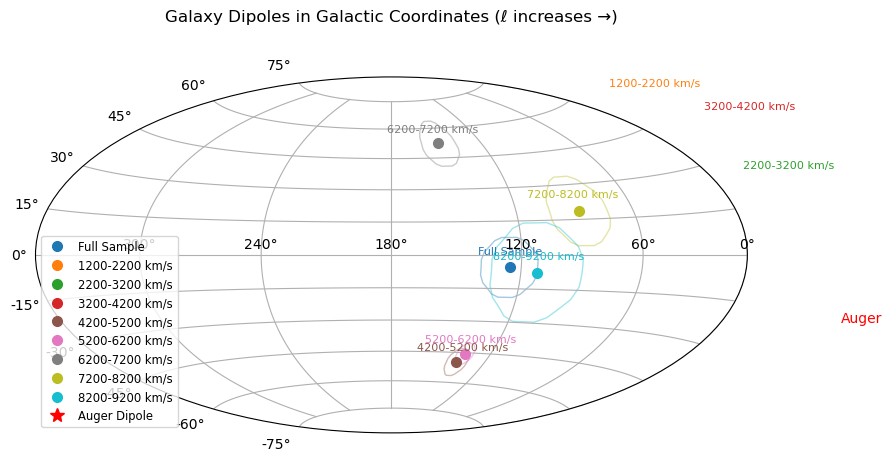

In [22]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.special import erfinv
import matplotlib.cm as cm

# === Load galaxy catalogue ===
gxs = ascii.read("../data/2MRSxWISE_sinBPTAGNs.txt")
RA_all = np.deg2rad(gxs['_RAJ2000'])
Dec_all = np.deg2rad(gxs['_DEJ2000'])
cz_all = gxs['cz']
weights_all = np.ones(len(RA_all))

# === Define cz bins ===
cz_bins = [(cz, cz + 1000) for cz in range(1200, 9000, 1000)]
cz_bins.insert(0, (1200, 9000))  # Add full sample

# === Setup colors and storage ===
n_bins = len(cz_bins)
colors = cm.get_cmap('tab10', n_bins)
dipole_results = {}

# === Auger reference dipole (ICRS) ===
auger_icrs = SkyCoord(ra=100.0 * u.deg, dec=-24.0 * u.deg, frame='icrs')
auger_gal = auger_icrs.galactic
auger_l = auger_gal.l.wrap_at(180 * u.deg).radian
auger_b = auger_gal.b.radian
auger_error_deg = 10.0

# === Loop through cz bins ===
for i, (cz_min, cz_max) in enumerate(cz_bins):
    label = "Full Sample" if i == 0 else f"{cz_min}-{cz_max} km/s"
    color = colors(i)

    # Filter galaxies
    mask = (cz_all > cz_min) & (cz_all < cz_max)
    RA = RA_all[mask]
    Dec = Dec_all[mask]
    weights = weights_all[mask]

    if len(RA) < 10:
        print(f"Skipping {label} — too few galaxies ({len(RA)})")
        continue

    W = np.sum(weights)

    # === 2D Rayleigh dipole ===
    a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
    b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
    r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)

    # === 3D dipole direction ===
    x = np.cos(Dec) * np.cos(RA)
    y = np.cos(Dec) * np.sin(RA)
    z = np.sin(Dec)
    X = np.sum(weights * x)
    Y = np.sum(weights * y)
    Z = np.sum(weights * z)
    norm = np.sqrt(X**2 + Y**2 + Z**2)
    X /= norm
    Y /= norm
    Z /= norm

    dipole_amp = norm / W
    alpha_d = np.rad2deg(np.arctan2(Y, X) % (2 * np.pi))
    delta_d = np.rad2deg(np.arcsin(Z))

    # === Convert dipole direction to Galactic coordinates
    dip_coord = SkyCoord(ra=alpha_d * u.deg, dec=delta_d * u.deg, frame='icrs')
    dip_gal = dip_coord.galactic
    l = dip_gal.l.wrap_at(180 * u.deg).radian
    b = dip_gal.b.radian

    # === Uncertainties and significance ===
    Weff = W**2 / np.sum(weights**2)
    sigma_r = np.sqrt(2 / Weff)
    sigma_phi_deg = np.rad2deg(sigma_r / r_alpha)
    P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)
    Zsig = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh)

    # === Angular separation from Auger ===
    separation = dip_coord.separation(auger_icrs).deg

    # === Store results ===
    dipole_results[label] = {
        'l': l,
        'b': b,
        'σ_phi': sigma_phi_deg,
        'Z': Zsig,
        'P': P_rayleigh,
        'separation': separation,
        'color': color
    }

    # === Print summary ===
    print(f"\n=== Dipole for {label} ===")
    print(f"RA = {alpha_d:.2f}°, Dec = {delta_d:.2f}°")
    print(f"Galactic l = {np.rad2deg(l):.2f}°, b = {np.rad2deg(b):.2f}°")
    print(f"Amplitude = {dipole_amp:.4f}, Significance = {Zsig:.2f} σ")
    print(f"Separation from Auger = {separation:.2f}°")

# === Galactic Dipole Sky Plot ===
plt.figure(figsize=(9, 5))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

# Custom tick labels: show 0 to 360 from left to right
xticks_deg = np.array([0, 60, 120, 180, 240, 300])
xticks_rad = np.radians(xticks_deg)
xtick_labels = [f"{int(t)}°" for t in xticks_deg]
ax.set_xticks(-xticks_rad + np.pi)  # Invert to make l increase left to right
ax.set_xticklabels(xtick_labels)

# === Plot dipoles
for label, res in dipole_results.items():
    l = res['l']
    b = res['b']
    color = res['color']

    # Wrap l to 0–2pi, invert for left→right
    l_plot = -l + np.pi

    ax.plot(l_plot, b, 'o', color=color, label=label, markersize=7)

    # Error circle
    radius = np.deg2rad(res['σ_phi'])
    circle = plt.Circle((l_plot, b), radius,
                        transform=ax.transData, edgecolor=color,
                        facecolor='none', alpha=0.4)
    ax.add_patch(circle)

    ax.text(l_plot, b + 0.1, label, ha='center', color=color, fontsize=8)

# === Auger Dipole
auger_l_plot = -auger_l + np.pi
ax.plot(auger_l_plot, auger_b, 'r*', markersize=10, label="Auger Dipole")

# Auger error circle
circle = plt.Circle((auger_l_plot, auger_b), np.deg2rad(auger_error_deg),
                    transform=ax.transData, edgecolor='red',
                    facecolor='none', linestyle='--', alpha=0.5)
ax.add_patch(circle)

ax.text(auger_l_plot, auger_b + 0.1, "Auger", ha='center', color='red')

plt.title("Galaxy Dipoles in Galactic Coordinates (ℓ increases →)", pad=40)
plt.legend(loc='lower left', fontsize='small')
plt.tight_layout()
plt.show()
